# MPA-MLF - Final project

Classification of room occupancy

Marek Černý, Dušan Kratochvíl

## 0. Import libraries

In [ ]:
from tensorflow import keras
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adagrad, Adam, AdamW
from keras.utils import to_categorical
import cv2
import os

## 1. Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Functions

Loading images from drive and adding them to array

In [ ]:
def load_images_from_folder(folder, n_img: int):
    images = []
    for i in range(n_img+1):
        img_path = os.path.join(folder, f"img_{i}.png")
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

Display random images from array

In [ ]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels = y_data[selected_ind]
  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img, cmap="gray")

  for id_label, label in enumerate(selected_labels):
    plt.text(20 + 51*id_label, 55, label)
  plt.axis('off')
  plt.show()

Separate RGB chanels from images

In [ ]:
def separate_rgb_from_images(images_array):
    # Separate RGB colors from array of images
    red_channel = images_array[:, :, :, 0]  # Extract Red channel
    green_channel = images_array[:, :, :, 1]  # Extract Green channel
    blue_channel = images_array[:, :, :, 2]  # Extract Blue channel

    return red_channel, green_channel, blue_channel

## 3. Create train data

In [ ]:
num_images = 16182
X_train =load_images_from_folder("/content/drive/MyDrive/Final Project/train_data_unlabeled",num_images)

num_images = 4796
X_test =load_images_from_folder("/content/drive/MyDrive/Final Project/test_data_unlabeled",num_images)

Saving data for time save

In [ ]:
np.save('/content/drive/MyDrive/Final Project/X_test_data_resized.npy', X_test)
np.save('/content/drive/MyDrive/Final Project/X_train_data_resized.npy', X_train)

## 4. Load created train data

In [ ]:
X_train = np.load('/content/drive/MyDrive/Final Project/X_train_data.npy')
X_test = np.load('/content/drive/MyDrive/Final Project/X_test_data.npy')
y_train = pd.read_csv('/content/drive/MyDrive/Final Project/y_train.csv')
y_train = y_train['target']

## 5. Display train data

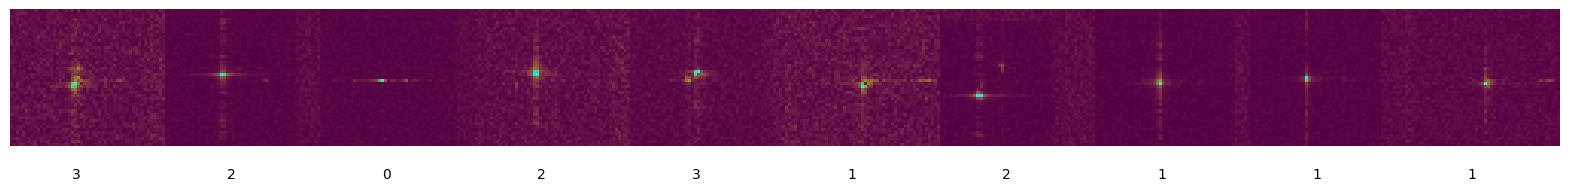

In [ ]:
display_random_images(X_train, y_train)

In [ ]:
red_channel, green_channel, blue_channel = separate_rgb_from_images(X_train)

<Figure size 640x480 with 0 Axes>

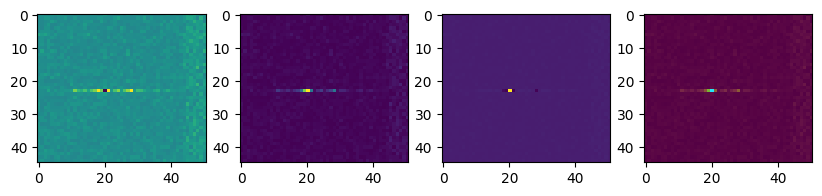

In [ ]:
plt.figure()
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs[0].imshow(red_channel[0])
axs[1].imshow(green_channel[0])
axs[2].imshow(blue_channel[0])
axs[3].imshow(X_train[0])
plt.show()

## 6. Preprocessing train data

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train_exp = np.expand_dims(X_train_split, -1)
#X_train_exp = np.expand_dims(X_train, -1)
#X_train_exp = np.expand_dims(green_channel, -1)
X_train_scaled = X_train_exp.astype('float32') / 255.0
y_train_encoded = to_categorical(y_train_split, num_classes=4)
#y_train_encoded = to_categorical(y_train, num_classes=4)

## 7. Create model

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='gelu', input_shape=(45, 51, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='gelu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='gelu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

In [ ]:
loss = 'categorical_crossentropy' # 1 - 'categorical_crossentropy' = 'categorical_focal_crossentropy' = 'poisson'
metrics = 'accuracy' # 1 - 'accuracy' = 'categorical_accuracy'
learning_rate = 0.001 #1 - 0.001; 2 - 0.01; 3 - 0.0001; 4 - 0.1
optimizer = AdamW(learning_rate = learning_rate) #1 - Adam; 2 - AdamW; 3 - Adagrad; 4 - SGD
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 49, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 24, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 22, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 11, 256)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25344)             0         
                                                                 
 dense (Dense)               (None, 256)               6

In [ ]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
324/324 [==============================] - 14s 24ms/step - loss: 0.6758 - accuracy: 0.7090 - val_loss: 0.4040 - val_accuracy: 0.8358
Epoch 2/20
324/324 [==============================] - 6s 20ms/step - loss: 0.3060 - accuracy: 0.8794 - val_loss: 0.2358 - val_accuracy: 0.9023
Epoch 3/20
324/324 [==============================] - 6s 20ms/step - loss: 0.2114 - accuracy: 0.9178 - val_loss: 0.1909 - val_accuracy: 0.9235
Epoch 4/20
324/324 [==============================] - 7s 22ms/step - loss: 0.1530 - accuracy: 0.9427 - val_loss: 0.1902 - val_accuracy: 0.9193
Epoch 5/20
324/324 [==============================] - 6s 19ms/step - loss: 0.1178 - accuracy: 0.9547 - val_loss: 0.1602 - val_accuracy: 0.9386
Epoch 6/20
324/324 [==============================] - 6s 20ms/step - loss: 0.0858 - accuracy: 0.9695 - val_loss: 0.1330 - val_accuracy: 0.9552
Epoch 7/20
324/324 [==============================] - 6s 20ms/step - loss: 0.0643 - accuracy: 0.9761 - val_loss: 0.1097 - val_accuracy: 0.962

## 8. Evaluate accuracy

In [ ]:
X_test_exp = np.expand_dims(X_test_split, -1)
X_test_preprocessed = X_test_exp.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test_split, num_classes=4)

In [ ]:
score = model.evaluate(X_test_preprocessed, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 0.11419542133808136
Test accuracy: 97.03429341316223 %


## 9. Create y_test

In [ ]:
y_test_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test_pred, axis=1)
y_test = pd.DataFrame({'id': range(len(y_test_labels)), 'target': y_test_labels})
y_test.to_csv('/content/drive/MyDrive/Final Project/y_test.csv', index=False)

150/150 [==============================] - 1s 6ms/step
